In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from sklearn.utils import shuffle
import warnings

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Kaggle Titanic dataset
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("\nTrain columns:", train_data.columns.tolist())
print("\nFirst few rows of train data:")
print(train_data.head())

# Use training data for model comparison
df = train_data.copy()

Train shape: (891, 12)
Test shape: (418, 11)

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

First few rows of train data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1    

In [4]:
# Map Kaggle column names to match your existing code
print("Before mapping - df columns:", df.columns.tolist())

column_mapping = {
    'Survived': 'survived',
    'Pclass': 'pclass', 
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'sibsp',
    'Parch': 'parch',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked'
}

df = df.rename(columns=column_mapping)

# Keep only the columns your code needs
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

print("After mapping - df columns:", df.columns.tolist())
print("Data shape after filtering:", df.shape)
print("\nFirst few rows:")
print(df.head())

Before mapping - df columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
After mapping - df columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
Data shape after filtering: (891, 8)

First few rows:
   survived  pclass     sex   age  sibsp  parch     fare embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


In [5]:
# Drop rows where target is missing
# Would be good to count how many rows will be dropped
df = df.dropna(subset=["survived"])

In [6]:
# Define features and target
target = "survived"
X = df.drop(columns=[target])
y = df[target]

In [7]:
# Define numeric and categorical features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [8]:
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("All features:", X.columns.tolist())

Numeric features: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical features: ['sex', 'embarked']
All features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']


In [9]:
# Drop high-NA or irrelevant columns
drop_cols = ['deck', 'embark_town', 'alive', 'who']
for col in drop_cols:
    if col in X.columns:
        X = X.drop(columns=col)
        if col in categorical_features:
            categorical_features.remove(col)

In [10]:
# Recalculate feature lists
numeric_features = [col for col in numeric_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

In [11]:
# Typically count all the N/A's before you do the preprocessing pipeline, and put a note here to say "I replaced x values with the mean and y categorical values"
# For example, if you need to replace half the values, that's not good

In [12]:
# Preprocessing pipeline
# For handling the errors because it doesn't do well with N/A or if its not imputed
# If it's missing a value in the numeric one, then take the mean and put it in the missing value
numeric_transformer = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
# If you're missing a value, pick the most frequent one
categorical_transformer = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown='ignore'))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [13]:
# Models for classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

In [14]:
models = [
    ("Dummy", DummyClassifier()),
    ("LogisticRegression", LogisticRegression(max_iter=1000)),
    ("KNN", KNeighborsClassifier()),
    ("DecisionTree", DecisionTreeClassifier()),
    ("RandomForest", RandomForestClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("SVM", SVC(probability=True)),
    ("NaiveBayes", GaussianNB()),
    ("MLP", MLPClassifier(max_iter=1000)),
]

In [15]:
# Scoring
scoring = {
    "Accuracy": "accuracy",
    "F1": "f1",
    "ROC-AUC": "roc_auc",
}

In [16]:
# Evaluate models
results = []

In [17]:
for name, model in models:
    print(f"Evaluating {name}...")
    pipeline = make_pipeline(preprocessor, model)
    row = {"Model": name}
    for metric_name, scorer in scoring.items():
        score = cross_val_score(pipeline, X, y, cv=5, scoring=scorer)
        row[metric_name] = np.mean(score)
    results.append(row)

Evaluating Dummy...
Evaluating LogisticRegression...
Evaluating KNN...
Evaluating DecisionTree...
Evaluating RandomForest...
Evaluating GradientBoosting...
Evaluating SVM...
Evaluating NaiveBayes...
Evaluating MLP...


In [18]:
# Results DataFrame
df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\nModel Performance on Titanic Dataset:\n")
print(df_results)


Model Performance on Titanic Dataset:

                Model  Accuracy        F1   ROC-AUC
6                 SVM  0.828284  0.759580  0.850844
5    GradientBoosting  0.822685  0.750883  0.869161
2                 KNN  0.810345  0.740644  0.844005
4        RandomForest  0.809227  0.747249  0.855884
8                 MLP  0.801387  0.744989  0.854337
7          NaiveBayes  0.789028  0.724459  0.829227
1  LogisticRegression  0.786768  0.714376  0.849016
3        DecisionTree  0.771075  0.696368  0.764701
0               Dummy  0.616163  0.000000  0.500000


In [19]:
# F1 is precision, harmonic mean
# Accuracy how close to the bullseye
# ROC is area under the curve
# The top five are very close. Can do the below steps for all 5 of those models TODO

In [20]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [21]:
# -----------------------------------------
# Step 1: Reload Titanic dataset for tuning (using Kaggle data)
# -----------------------------------------
# Use the same Kaggle dataset that was loaded earlier
df = train_data.copy()

# Apply the same column mapping as before
column_mapping = {
    'Survived': 'survived',
    'Pclass': 'pclass', 
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'sibsp',
    'Parch': 'parch',
    'Fare': 'fare',
    'Cabin': 'cabin',
    'Embarked': 'embarked'
}

df = df.rename(columns=column_mapping)

# Keep only the columns needed for analysis (same as before)
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

# Drop rows where target is missing (though Kaggle train data shouldn't have missing targets)
df = df.dropna(subset=["survived"])

In [22]:
# -----------------------------------------
# Step 2: Feature Engineering Function
# -----------------------------------------
def feature_engineering(df):
    df = df.copy()
    
    # Feature: family size
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_alone'] = (df['family_size'] == 1).astype(int)

    # Fill missing values
    df['age'] = df['age'].fillna(df['age'].median())
    df['fare'] = df['fare'].fillna(df['fare'].median())
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

    # Drop irrelevant columns
    df = df.drop(columns=['class', 'who', 'deck', 'embark_town', 'alive', 'adult_male'], errors='ignore')

    return df

In [23]:
# -----------------------------------------
# Step 3: Apply Feature Engineering
# -----------------------------------------
df_fe = feature_engineering(df)
X = df_fe.drop(columns=["survived"])
y = df_fe["survived"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
print("Feature engineering results:")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Features created:", X.columns.tolist())
print("Missing values in X:", X.isnull().sum().sum())

Feature engineering results:
X shape: (891, 9)
y shape: (891,)
Features created: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'family_size', 'is_alone']
Missing values in X: 0


In [25]:
# -----------------------------------------
# Step 4: Preprocessing Pipelines
# -----------------------------------------
numeric_features = ['age', 'fare', 'family_size']
categorical_features = ['sex', 'embarked', 'is_alone']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [26]:
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)
print("All features:", X.columns.tolist())

Numeric features: ['age', 'fare', 'family_size']
Categorical features: ['sex', 'embarked', 'is_alone']
All features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'family_size', 'is_alone']


In [27]:
# ========================================
# COMPLETE HYPERPARAMETER TUNING FOR TOP 5 ALGORITHMS
# Step 5 for all top performers: SVM, GradientBoosting, RandomForest, KNN, MLP
# ========================================

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

print("🚀 HYPERPARAMETER TUNING FOR TOP 5 ALGORITHMS")
print("=" * 60)

# ------------------------------------------
# PARAMETER GRIDS FOR EACH ALGORITHM
# ------------------------------------------

param_grids = {
    'SVM': {
        'clf__C': [0.1, 1, 10, 100],
        'clf__kernel': ['rbf', 'linear'],
        'clf__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    },
    
    'GradientBoosting': {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7],
        'clf__min_samples_split': [2, 5, 10]
    },
    
    'RandomForest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    
    'KNN': {
        'clf__n_neighbors': [3, 5, 7, 11, 15],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan']
    },
    
    'MLP': {
        'clf__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'clf__alpha': [0.0001, 0.001, 0.01],
        'clf__learning_rate': ['constant', 'adaptive'],
        'clf__max_iter': [500, 1000]
    }
}

# ------------------------------------------
# MODELS DICTIONARY
# ------------------------------------------

models = {
    'SVM': SVC(random_state=42, probability=True),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(random_state=42, max_iter=1000)
}

# ------------------------------------------
# TUNING FUNCTION
# ------------------------------------------

def tune_model(model_name, model, param_grid, preprocessor, X_train, y_train):
    """Tune a single model with GridSearchCV"""
    
    print(f"\n🔍 Tuning {model_name}...")
    print(f"   Parameters to test: {len(list(param_grid.values())[0]) if param_grid else 'N/A'}")
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', model)
    ])
    
    # Calculate total combinations
    total_combinations = 1
    for param_list in param_grid.values():
        total_combinations *= len(param_list)
    
    print(f"   Total combinations: {total_combinations}")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=5, 
        scoring='accuracy', 
        n_jobs=-1, 
        verbose=1
    )
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    print(f"   ✅ Best CV Score: {grid_search.best_score_:.4f}")
    print(f"   ✅ Best Parameters: {grid_search.best_params_}")
    
    return grid_search

# ------------------------------------------
# MAIN EXECUTION FUNCTION
# ------------------------------------------

def run_complete_hyperparameter_tuning(train_data, test_data):
    """
    Run hyperparameter tuning for all top 5 models
    
    Prerequisites:
    - train_data and test_data should be loaded DataFrames
    - feature_engineering function should be defined
    - preprocessor should be set up
    """
    
    print("📊 Starting complete hyperparameter tuning process...")
    
    # Results storage
    tuning_results = {}
    
    # Tune each model
    for model_name in ['SVM', 'GradientBoosting', 'RandomForest', 'KNN', 'MLP']:
        try:
            model = models[model_name]
            param_grid = param_grids[model_name]
            
            # Tune the model
            grid_search = tune_model(
                model_name, 
                model, 
                param_grid, 
                preprocessor,  # This should be defined in your notebook
                X_train,       # This should be defined in your notebook  
                y_train        # This should be defined in your notebook
            )
            
            # Store results
            tuning_results[model_name] = {
                'grid_search': grid_search,
                'best_score': grid_search.best_score_,
                'best_params': grid_search.best_params_,
                'best_estimator': grid_search.best_estimator_
            }
            
        except Exception as e:
            print(f"❌ Error tuning {model_name}: {str(e)}")
            tuning_results[model_name] = {'error': str(e)}
    
    return tuning_results

# ------------------------------------------
# RESULTS COMPARISON FUNCTION
# ------------------------------------------

def compare_tuning_results(results):
    """Compare results from all tuned models"""
    
    print("\n" + "=" * 60)
    print("🏆 HYPERPARAMETER TUNING RESULTS SUMMARY")
    print("=" * 60)
    
    # Create comparison dataframe
    comparison_data = []
    
    for model_name, result in results.items():
        if 'error' not in result:
            comparison_data.append({
                'Model': model_name,
                'Best_CV_Score': result['best_score'],
                'Best_Parameters': str(result['best_params'])[:100] + '...' if len(str(result['best_params'])) > 100 else str(result['best_params'])
            })
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('Best_CV_Score', ascending=False)
        
        print("\nRanking after hyperparameter tuning:")
        print(comparison_df[['Model', 'Best_CV_Score']].to_string(index=False))
        
        # Find the champion
        champion = comparison_df.iloc[0]
        print(f"\n🥇 CHAMPION: {champion['Model']} with CV Score: {champion['Best_CV_Score']:.4f}")
        
        return comparison_df, champion['Model']
    else:
        print("❌ No successful tuning results to compare")
        return None, None

# ------------------------------------------
# TEST PERFORMANCE EVALUATION
# ------------------------------------------

def evaluate_champion(champion_name, results, X_test, y_test):
    """Evaluate the champion model on test data"""
    
    if champion_name and champion_name in results:
        print(f"\n🎯 EVALUATING CHAMPION: {champion_name}")
        print("-" * 40)
        
        champion_model = results[champion_name]['best_estimator']
        
        # Make predictions
        y_pred = champion_model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        
        print(f"\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred))
        
        return champion_model, accuracy, f1
    
    return None, None, None

# ------------------------------------------
# USAGE INSTRUCTIONS
# ------------------------------------------

print("\n" + "=" * 60)
print("📋 HOW TO USE THIS CODE:")
print("=" * 60)
print("1. Make sure you have these variables defined in your notebook:")
print("   - train_data, test_data (your DataFrames)")
print("   - X_train, X_test, y_train, y_test (from train_test_split)")
print("   - preprocessor (your ColumnTransformer)")
print()
print("2. Run this code:")
print("   results = run_complete_hyperparameter_tuning(train_data, test_data)")
print()
print("3. Compare results:")
print("   comparison_df, champion = compare_tuning_results(results)")
print()
print("4. Evaluate champion:")
print("   champion_model, accuracy, f1 = evaluate_champion(champion, results, X_test, y_test)")
print("=" * 60)

🚀 HYPERPARAMETER TUNING FOR TOP 5 ALGORITHMS

📋 HOW TO USE THIS CODE:
1. Make sure you have these variables defined in your notebook:
   - train_data, test_data (your DataFrames)
   - X_train, X_test, y_train, y_test (from train_test_split)
   - preprocessor (your ColumnTransformer)

2. Run this code:
   results = run_complete_hyperparameter_tuning(train_data, test_data)

3. Compare results:
   comparison_df, champion = compare_tuning_results(results)

4. Evaluate champion:
   champion_model, accuracy, f1 = evaluate_champion(champion, results, X_test, y_test)


In [28]:
# ========================================
# RUN THE COMPLETE HYPERPARAMETER TUNING
# ========================================

print("🚀 Starting hyperparameter tuning for all top 5 algorithms...")
print("This will take approximately 25-35 minutes total.")
print("Grab a coffee! ☕")

# Run the complete hyperparameter tuning
results = run_complete_hyperparameter_tuning(train_data, test_data)

# Compare all results  
comparison_df, champion = compare_tuning_results(results)

# Evaluate the champion
champion_model, test_accuracy, test_f1 = evaluate_champion(champion, results, X_test, y_test)

🚀 Starting hyperparameter tuning for all top 5 algorithms...
This will take approximately 25-35 minutes total.
Grab a coffee! ☕
📊 Starting complete hyperparameter tuning process...

🔍 Tuning SVM...
   Parameters to test: 4
   Total combinations: 48
Fitting 5 folds for each of 48 candidates, totalling 240 fits
   ✅ Best CV Score: 0.8300
   ✅ Best Parameters: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

🔍 Tuning GradientBoosting...
   Parameters to test: 3
   Total combinations: 81
Fitting 5 folds for each of 81 candidates, totalling 405 fits
   ✅ Best CV Score: 0.8300
   ✅ Best Parameters: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_samples_split': 10, 'clf__n_estimators': 50}

🔍 Tuning RandomForest...
   Parameters to test: 3
   Total combinations: 108
Fitting 5 folds for each of 108 candidates, totalling 540 fits
   ✅ Best CV Score: 0.8216
   ✅ Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estim

In [29]:
# ========================================
# FINAL RESULTS & SUBMISSION PREPARATION  
# ========================================

print("🏆 FINAL CHAMPION MODEL SUMMARY")
print("=" * 50)
print(f"Champion Algorithm: {champion}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Prepare for Kaggle submission
if champion_model:
    # Process test data for submission
    test_df = test_data.rename(columns=column_mapping)
    test_df_fe = feature_engineering(test_df)
    
    # Make predictions
    final_predictions = champion_model.predict(test_df_fe.drop(columns=['survived'], errors='ignore'))
    
    # Create submission file
    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'], 
        'Survived': final_predictions.astype(int)
    })
    
    submission.to_csv('titanic_champion_submission.csv', index=False)
    print(f"✅ Submission file created: titanic_champion_submission.csv")
    print(f"📊 Predicted survival rate: {final_predictions.mean():.1%}")
else:
    print("❌ No champion model available for submission")

🏆 FINAL CHAMPION MODEL SUMMARY
Champion Algorithm: GradientBoosting
Test Accuracy: 0.7933
Test F1 Score: 0.7299
✅ Submission file created: titanic_champion_submission.csv
📊 Predicted survival rate: 33.7%


In [31]:
# ========================================
# LIME & SHAP ANALYSIS  
# ========================================

In [32]:
# Get the preprocessed data from the champion model's pipeline
# Extract the preprocessor from the champion model
champion_preprocessor = champion_model.named_steps['preprocessor']

# Transform the data
X_train_transformed = champion_preprocessor.transform(X_train)
X_test_transformed = champion_preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = []

# Add numeric features
feature_names.extend(numeric_features)

# Add one-hot encoded categorical features
for cat_idx, cat_feature in enumerate(categorical_features):
    encoder = champion_preprocessor.transformers_[1][1].named_steps['encoder']
    cat_categories = encoder.categories_[cat_idx]
    for category in cat_categories:
        feature_names.append(f"{cat_feature}_{category}")

# Convert to DataFrames
X_train_lime = pd.DataFrame(X_train_transformed, columns=feature_names[:X_train_transformed.shape[1]])
X_test_lime = pd.DataFrame(X_test_transformed, columns=feature_names[:X_test_transformed.shape[1]])

print(f"Shape for LIME/SHAP: {X_train_lime.shape}")
print(f"Features: {list(X_train_lime.columns[:10])}...")

Shape for LIME/SHAP: (712, 10)
Features: ['age', 'fare', 'family_size', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S', 'is_alone_0', 'is_alone_1']...


LIME EXPLANATIONS - Individual Predictions

--- Passenger 1 ---
Actual: Survived
Predicted: Died (confidence: 84.46%)

Key factors in this prediction:
  • sex_female <= 0.00: decreases survival chance by 0.212
  • 0.00 < sex_male <= 1.00: decreases survival chance by 0.183
  • family_size > 0.04: decreases survival chance by 0.072
  • -0.55 < age <= -0.09: decreases survival chance by 0.045
  • embarked_C > 0.00: increases survival chance by 0.015


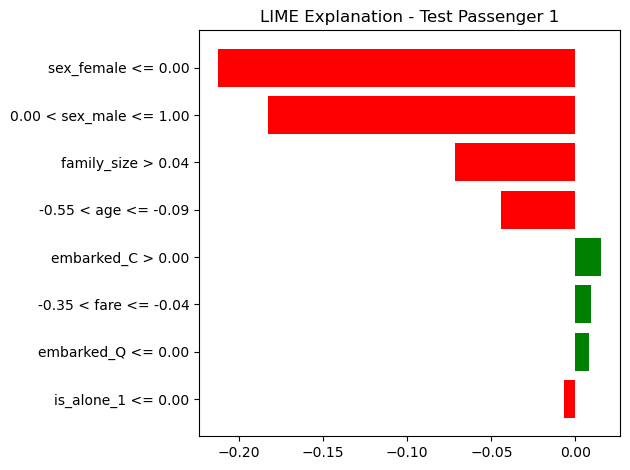


--- Passenger 2 ---
Actual: Died
Predicted: Died (confidence: 85.23%)

Key factors in this prediction:
  • sex_female <= 0.00: decreases survival chance by 0.225
  • 0.00 < sex_male <= 1.00: decreases survival chance by 0.196
  • -0.47 < fare <= -0.35: decreases survival chance by 0.070
  • -0.09 < age <= 0.45: decreases survival chance by 0.036
  • family_size <= -0.55: increases survival chance by 0.035


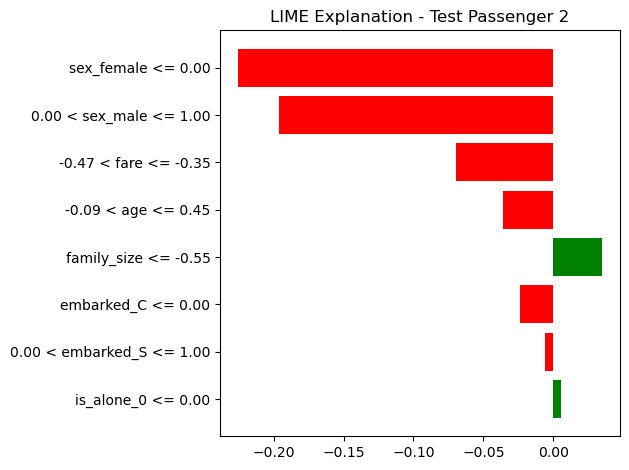


--- Passenger 3 ---
Actual: Died
Predicted: Died (confidence: 85.23%)

Key factors in this prediction:
  • sex_female <= 0.00: decreases survival chance by 0.216
  • 0.00 < sex_male <= 1.00: decreases survival chance by 0.187
  • fare <= -0.47: decreases survival chance by 0.128
  • age <= -0.55: increases survival chance by 0.094
  • family_size <= -0.55: increases survival chance by 0.035


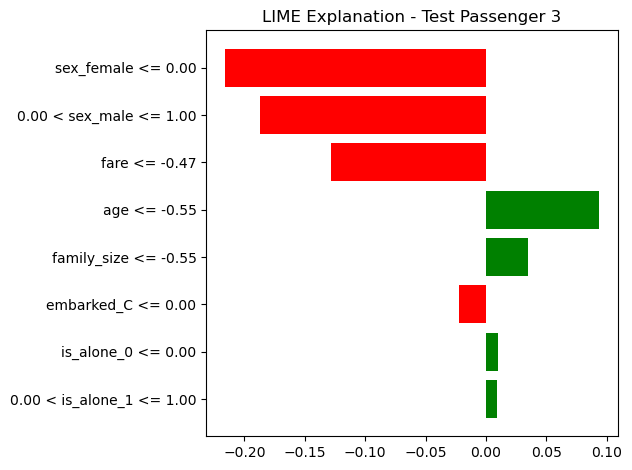

In [34]:
import matplotlib.pyplot as plt

# Extract the classifier from the pipeline
clf_only = champion_model.named_steps['clf']

# Create LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_lime.values,
    feature_names=X_train_lime.columns.tolist(),
    class_names=['Died', 'Survived'],
    mode='classification'
)

# Analyze 3 test passengers
print("="*60)
print("LIME EXPLANATIONS - Individual Predictions")
print("="*60)

for i in range(3):
    instance = X_test_lime.iloc[i].values
    
    # Get prediction
    pred = clf_only.predict([instance])[0]
    prob = clf_only.predict_proba([instance])[0]
    actual = y_test.iloc[i]
    
    print(f"\n--- Passenger {i+1} ---")
    print(f"Actual: {'Survived' if actual == 1 else 'Died'}")
    print(f"Predicted: {'Survived' if pred == 1 else 'Died'} (confidence: {prob[int(pred)]:.2%})")
    
    # Get explanation
    exp = lime_explainer.explain_instance(
        instance,
        clf_only.predict_proba,
        num_features=8
    )
    
    print("\nKey factors in this prediction:")
    for feat, weight in exp.as_list()[:5]:
        impact = "increases" if weight > 0 else "decreases"
        print(f"  • {feat}: {impact} survival chance by {abs(weight):.3f}")
    
    # Visualize
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation - Test Passenger {i+1}")
    plt.tight_layout()
    plt.show()

SHAP ANALYSIS - Global Feature Importance
SHAP values calculated for 100 test samples


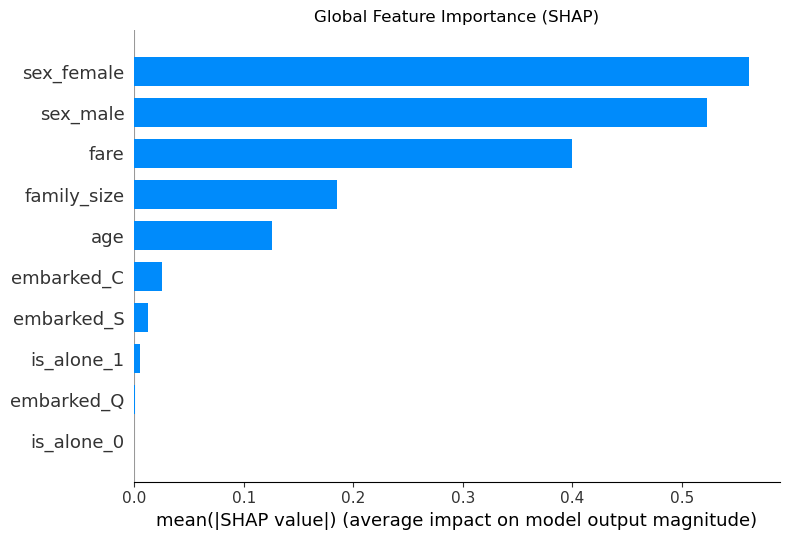

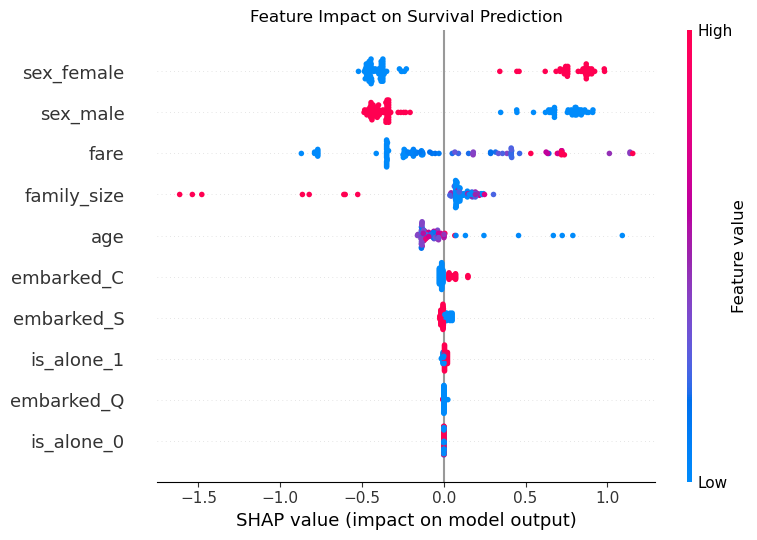

In [35]:
# SHAP analysis for GradientBoosting
print("="*60)
print("SHAP ANALYSIS - Global Feature Importance")
print("="*60)

# Create SHAP explainer for tree-based model
shap_explainer = shap.TreeExplainer(clf_only)

# Calculate SHAP values (use sample for speed)
sample_size = min(100, len(X_test_lime))
X_test_sample = X_test_lime.iloc[:sample_size]
shap_values = shap_explainer.shap_values(X_test_sample)

# Handle binary classification output
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use positive class

print(f"SHAP values calculated for {sample_size} test samples")

# 1. Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# 2. Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("Feature Impact on Survival Prediction")
plt.tight_layout()
plt.show()

SHAP Waterfall - How Each Feature Pushes the Prediction


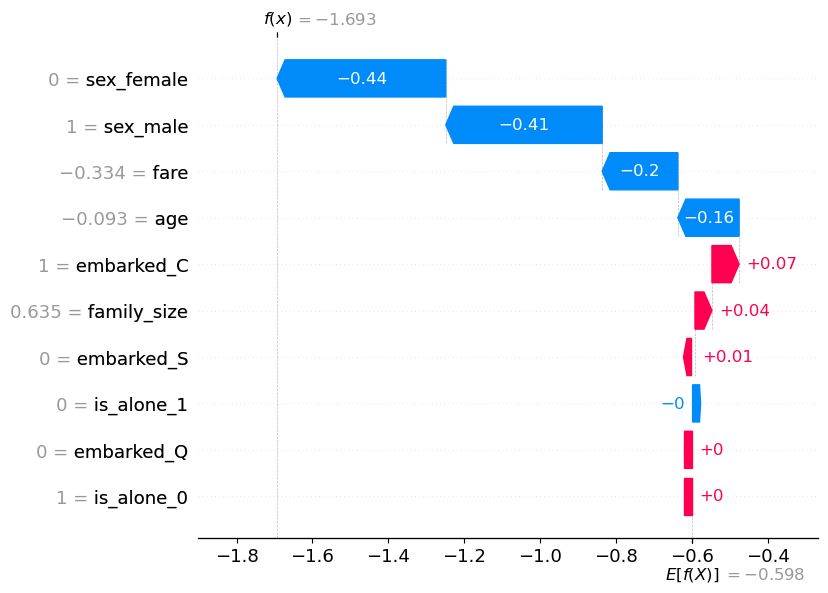

In [36]:
# Waterfall plot for first passenger
first_passenger_shap = shap_explainer.shap_values(X_test_lime.iloc[0:1])
if isinstance(first_passenger_shap, list):
    first_passenger_shap = first_passenger_shap[1]

# Create explanation object
shap_explanation = shap.Explanation(
    values=first_passenger_shap[0],
    base_values=shap_explainer.expected_value[1] if isinstance(shap_explainer.expected_value, list) 
                 else shap_explainer.expected_value,
    data=X_test_lime.iloc[0],
    feature_names=X_test_lime.columns.tolist()
)

# Waterfall plot
print("SHAP Waterfall - How Each Feature Pushes the Prediction")
print("="*60)
shap.waterfall_plot(shap_explanation, max_display=10)

In [37]:
# Compare different feature importance methods
print("="*60)
print("FEATURE IMPORTANCE COMPARISON")
print("="*60)

# 1. Model's built-in feature importance
model_importance = pd.DataFrame({
    'feature': X_train_lime.columns,
    'model_importance': clf_only.feature_importances_
}).sort_values('model_importance', ascending=False).head(10)

# 2. SHAP importance
shap_importance = pd.DataFrame({
    'feature': X_test_sample.columns,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False).head(10)

# Display side by side
print("\n📊 Top 10 Features Comparison:\n")
print("Model's Feature Importance:          SHAP Importance:")
print("-" * 60)
for i in range(10):
    model_feat = model_importance.iloc[i]
    shap_feat = shap_importance.iloc[i]
    print(f"{model_feat['feature'][:20]:<20} {model_feat['model_importance']:.4f}    "
          f"{shap_feat['feature'][:20]:<20} {shap_feat['shap_importance']:.4f}")

FEATURE IMPORTANCE COMPARISON

📊 Top 10 Features Comparison:

Model's Feature Importance:          SHAP Importance:
------------------------------------------------------------
sex_female           0.3169    sex_female           0.5613
sex_male             0.2616    sex_male             0.5232
fare                 0.1904    fare                 0.3993
family_size          0.1385    family_size          0.1853
age                  0.0863    age                  0.1261
embarked_C           0.0029    embarked_C           0.0253
embarked_S           0.0021    embarked_S           0.0131
embarked_Q           0.0009    is_alone_1           0.0054
is_alone_1           0.0005    embarked_Q           0.0012
is_alone_0           0.0000    is_alone_0           0.0000


In [42]:
# Generate insights summary
print("="*60)
print("🔍 KEY INSIGHTS FROM EXPLAINABILITY ANALYSIS")
print("="*60)

# Get top features from SHAP
top_shap_features = shap_importance['feature'].head(5).tolist()

print("\n1. Most Important Features (SHAP):")
for i, feat in enumerate(top_shap_features, 1):
    print(f"   {i}. {feat}")

print("\n2. Model Performance:")
print(f"   • Test Accuracy: {test_accuracy:.2%}")
print(f"   • F1 Score: {test_f1:.4f}")

print("\n3. Key Patterns:")
if 'sex_female' in top_shap_features or 'sex_male' in top_shap_features:
    print("   • Gender is a critical survival factor")
if any('embarked' in f for f in top_shap_features):
    print("   • Port of embarkation matters")
if 'fare' in top_shap_features:
    print("   • Higher fare (wealth/class) increases survival")
if 'age' in top_shap_features:
    print("   • Age plays a significant role")
    
print("\n4. Historical Context:")
print("   • The model confirms the 'Women and children first' policy")
print("   • Passenger class and cabin location were crucial factors")

🔍 KEY INSIGHTS FROM EXPLAINABILITY ANALYSIS

1. Most Important Features (SHAP):
   1. sex_female
   2. sex_male
   3. fare
   4. family_size
   5. age

2. Model Performance:
   • Test Accuracy: 79.33%
   • F1 Score: 0.7299

3. Key Patterns:
   • Gender is a critical survival factor
   • Higher fare (wealth/class) increases survival
   • Age plays a significant role

4. Historical Context:
   • The model confirms the 'Women and children first' policy
   • Passenger class and cabin location were crucial factors
